### Proyecto Programación Avanzada: Estudio de la distribución del género Eucalyptus en la Comunidad Autónoma de Cantabria
#### Práctica 1: EDA
#### 1.1 Estudio de reflectividad en la Comunidad.

En esta práctica vamos a realizar un análisis exploratorio de datos para el género de eucaliptos, 
debido a que son una especie invasora en la península.

Partiremos de datos en formatos shape que consisten en la ubicacion comprobada de eucaliptos en la peninsula y en Cantabria, tanto en una capa de poligonos correspondiente al mapa forestal de España disponibles en: miteco.gob.es. Este mapa forestal ha sido depurado para obtener solo los poligonos que tienen especies de eucalipto. 
Asimismo se ha utilizado una capa de datos como puntos concretos de eucaliptos en la peninsula.  En el formato raster trabajaremos con imagenes Sentinel 2A, de nivel 2, por lo que no será necesario corregir reflectividades. Estas imagenes se descargan como una imagen en formato jp2 por cada banda, siendo un total de 13 bandas espectrales, y 13 imagenes por cuadrante. En la comunidad de cantabria hacen un total de 4 cuadrantes para cubrir el area entera por lo que será necesaria tanto una transformación en multiimagen como una composicion en mosaico para obtener la imagen con la que trataremos finalmente. Todo esto lo haremos un poco mas adelante.

Primero importaremos las librerias necesarias para este apartado.

In [ ]:
import os
import getpass
import sys
import pandas as pd
import geopandas as gpd
import numpy as np
import xarray
import shapely
import matplotlib.pyplot as plt
import rasterio
import glob

Ahora, solucionamos el problema con la librería PROJ y GDAL

In [5]:
usuario = getpass.getuser()

# os.environ['GDAL_DATA'] = f'/opt/anaconda3/envs/geoenv/share/gdal'
# os.environ['PROJ_LIB'] = f'/opt/anaconda3/envs/geoenv/share'

# en windows
os.environ['GDAL_DATA'] = f'C:\\Users\\{usuario}\\anaconda3\\envs\\advprog\\Library\\share\\gdal'
os.environ['PROJ_LIB'] = f'C:\\Users\\{usuario}\\anaconda3\\envs\\advprog\\Library\\share\\proj'

Ahora vamos a establecer las rutas en las que se encuentran los geodatos:

In [8]:
#sys.argv[1] = "C:\\Users\\angel\\Documents\\Programacion_avanzada\\practicas\\Geodatos\\" #Ángel
sys.argv[1] = "E:\\advprog\\p1\\Geodatos\\" #Edu

euc_points = sys.argv[1] + "eucaliptos_españa_puntos\\eucalyptus_points.csv"
euc_mfe = sys.argv[1] + "Eucaliptales_Cornisa_Cantabrica\\Eucaliptales_Cornisa_Cantabrica.shp"

Como ya hemos comentado, las imagenes en raster, descargadas del portal oficial de Sentinel 2A, aparecen en imagenes independientes por cada banda, y para Cantabria, son 4 imagenes diferentes, por lo que lo primero es unir las bandas en imagenes multibanda
y tras eso hacer un mosaico para obtener la imagen completa. Tras esto, queda una imagen con la zona cantabra en el centro, pero todo lo demas es información sin interés, que no queremos en nuestro estudio estadístico de la zona, por lo que querremos hacer un recorte de esta ultima imagen, con la forma de la comunidad autonoma de Cantabria.

La siguiente celda genera una lista con las rutas de nuestras 4 imagenes que queremos transformar a multibanda.

In [ ]:
#ruta1 = input("Introduzca la rutas de la carpeta que contiene las bandas en orden:")
#ruta2 = input("Introduzca la rutas de la carpeta que contiene las bandas en orden:")
#ruta3 = input("Introduzca la rutas de la carpeta que contiene las bandas en orden:")
#ruta4 = input("Introduzca la rutas de la carpeta que contiene las bandas en orden:")
ruta1 = "S2C_MSIL2A_20250219T111131_N0511_R137_T30TUN_20250219T152713.SAFE\\GRANULE\\L2A_T30TUN_A002395_20250219T111258\\IMG_DATA\\R20m"
ruta2 = "S2C_MSIL2A_20250219T111131_N0511_R137_T30TUP_20250219T152713.SAFE\\GRANULE\\L2A_T30TUP_A002395_20250219T111258\\IMG_DATA\\R20m"
ruta3 = "S2C_MSIL2A_20250219T111131_N0511_R137_T30TVN_20250219T152713.SAFE\\GRANULE\\L2A_T30TVN_A002395_20250219T111258\\IMG_DATA\\R20m"
ruta4 = "S2C_MSIL2A_20250219T111131_N0511_R137_T30TVP_20250219T152713.SAFE\\GRANULE\\L2A_T30TVP_A002395_20250219T111258\\IMG_DATA\\R20m"
rutas = []
rutas.append(ruta1)
rutas.append(ruta2)
rutas.append(ruta3)
rutas.append(ruta4)
rutas

Lo siguiente genera las 4 imagenes multibanda en formato .tif en las distintas rutas. Y añade cada ruta, dentro del bucle, en un objeto llamado salidas_raster
que utilizaremos mas adelante.

In [ ]:
salidas_raster = []
for i, ruta in enumerate(rutas):
    raster_files = sorted(glob.glob(sys.argv[1] + "imagenes/" + ruta + "/*.jp2"))
    
    if not raster_files:
        print(f"No se encontraron archivos en {ruta}")
        continue
    
    bands = []
    with rasterio.open(raster_files[0]) as src:
        meta = src.meta.copy()
        meta.update({"count": len(raster_files), "driver": "GTiff"})
    
    for file in raster_files:
        with rasterio.open(file) as src:
            bands.append(src.read(1))
    
    stacked_array = np.stack(bands)
    output_tif = sys.argv[1] + "imagenes/" + ruta + "/salida/imagen_combinada_" + str(i+1) + ".tif"
    
    with rasterio.open(output_tif, "w", **meta) as dst:
        for j in range(stacked_array.shape[0]):
            dst.write(stacked_array[j], j + 1)
    salidas_raster.append(output_tif)
    print(f"Archivo guardado en: {output_tif}")


Ahora quedaría hacer el mosaico, con las rutas de las multiimagenes que acabamos de generar, que tenemos en el objeto salidas_raster.

In [ ]:
from rasterio.merge import merge

# Abrimos los archivos de salida
src_files_to_mosaic = [rasterio.open(file) for file in salidas_raster]

# juntamos las imagnees con merge
mosaic, out_transform = merge(src_files_to_mosaic, method="first")  # "first" prioriza el primer píxel encontrado

# copiamos los metadatos
out_meta = src_files_to_mosaic[0].meta.copy()
out_meta.update({
    "height": mosaic.shape[1],  
    "width": mosaic.shape[2],   
    "transform": out_transform  
})

# Guardar la imagen final
output_tif = sys.argv[1] + "imagenes\\mosaico.tif"
with rasterio.open(output_tif, "w", **out_meta) as dest:
    for i in range(mosaic.shape[0]):  # (Para mantener el orden de las bandas)
        dest.write(mosaic[i], i + 1)

print(f"Mosaico guardado en: {output_tif}")

# Y cerrar los rasters
for src in src_files_to_mosaic:
    src.close()

Ahora quedaría hacer el recorte de la comunidad autónoma para ya tener los datos finales con los que queremos trabajar.

Ya teniendo nuestros datos preparados, podemos proceder a hacer el EDA.

## EDA de datos en formato shape:

Ahora, vamos a empezar a tratar los datos, primero, hemos descargado de GBIF datos puntuales para toda España, vamos a tratarlos y luego los convertiremos en un geodato gracias a los datos de latitud y longitud.

In [9]:
eucpoints_tabla = pd.read_table(euc_points)

C:\Users\Edush\AppData\Local\Temp\ipykernel_11180\604695395.py:1: DtypeWarning: Columns (10,14,16,17,29,39,40,41,43,44,46,48) have mixed types. Specify dtype option on import or set low_memory=False.
  eucpoints_tabla = pd.read_table(euc_points)


Esto nos indica que la tabla tiene "mixed types", por lo cual, da problemas. Vamos a solucionarlo

In [10]:
eucpoints_tabla = pd.read_table(euc_points, low_memory=False)
print(eucpoints_tabla.dtypes)

gbifID                                int64
datasetKey                           object
occurrenceID                         object
kingdom                              object
phylum                               object
class                                object
order                                object
family                               object
genus                                object
species                              object
infraspecificEpithet                 object
taxonRank                            object
scientificName                       object
verbatimScientificName               object
verbatimScientificNameAuthorship     object
countryCode                          object
locality                             object
stateProvince                        object
occurrenceStatus                     object
individualCount                     float64
publishingOrgKey                     object
decimalLatitude                     float64
decimalLongitude                

Aquellas con el tipo "object" son las que representan tipos mixtos que dan problema, vamos a ver cuáles nos hacen falta y cuales podemos eliminar

In [11]:
eucpoints_tabla = eucpoints_tabla.drop(columns=["datasetKey", "occurrenceID", "infraspecificEpithet",
                                             "taxonRank", "scientificName", "verbatimScientificName", 
                                             "verbatimScientificNameAuthorship", "publishingOrgKey", 
                                             "eventDate", "basisOfRecord", "institutionCode", "collectionCode", 
                                             "catalogNumber", "recordNumber", "identifiedBy", "dateIdentified", 
                                             "license", "rightsHolder", "recordedBy", "establishmentMeans", 
                                             "mediaType", "issue", "locality", "typeStatus", "stateProvince", 
                                                "occurrenceStatus", "gbifID", "kingdom", "phylum", "class", "order", 
                                               "countryCode", "individualCount", "family", "elevationAccuracy", "depth",
                                               "lastInterpreted", "taxonKey", "speciesKey", "coordinateUncertaintyInMeters", 
                                               "coordinatePrecision", "depthAccuracy", "day", "month", "year"], errors="ignore")
eucpoints_tabla

,genus,species,decimalLatitude,decimalLongitude,elevation
0,Eucalyptus,NaN,NaN,NaN,NaN
1,Eucalyptus,Eucalyptus globulus,43.516539,-5.270636,157.00
2,Eucalyptus,Eucalyptus globulus,42.567851,-8.873670,80.38
3,Eucalyptus,Eucalyptus globulus,42.928194,-8.113348,489.00
4,Eucalyptus,Eucalyptus globulus,42.889623,-8.571294,393.00
...,...,...,...,...,...
178943,Eucalyptus,Eucalyptus reducta,NaN,NaN,NaN
178944,Eucalyptus,Eucalyptus globulus,39.779999,2.700000,1.00
178945,Eucalyptus,Eucalyptus globulus,39.770000,2.700000,1.00
178946,Eucalyptus,Eucalyptus globulus,NaN,NaN,NaN


Ahora vamos a eliminar aquellas que tengan vacía algunas de las coordenadas vacías

In [12]:
eucpoints_tabla["decimalLatitude"] = eucpoints_tabla["decimalLatitude"].replace("", np.nan)
eucpoints_tabla["decimalLongitude"] = eucpoints_tabla["decimalLongitude"].replace("", np.nan)

eucpoints_tabla = eucpoints_tabla.dropna(subset=["decimalLatitude", "decimalLongitude"])

eucpoints_tabla

,genus,species,decimalLatitude,decimalLongitude,elevation
1,Eucalyptus,Eucalyptus globulus,43.516539,-5.270636,157.00
2,Eucalyptus,Eucalyptus globulus,42.567851,-8.873670,80.38
3,Eucalyptus,Eucalyptus globulus,42.928194,-8.113348,489.00
4,Eucalyptus,Eucalyptus globulus,42.889623,-8.571294,393.00
5,Eucalyptus,Eucalyptus globulus,43.714230,-7.611280,NaN
...,...,...,...,...,...
178936,Eucalyptus,Eucalyptus camaldulensis,28.110870,-16.578650,530.00
178937,Eucalyptus,Eucalyptus camaldulensis,28.117600,-16.587020,705.00
178944,Eucalyptus,Eucalyptus globulus,39.779999,2.700000,1.00
178945,Eucalyptus,Eucalyptus globulus,39.770000,2.700000,1.00


Lo siguiente, será transformarlo a geodato para poder extraer solo aquellos que se encuentran dentro del shapefile de Cantabria

In [13]:
from shapely.geometry import Point
from pyproj import CRS

eucpoints = eucpoints_tabla.copy()
eucpoints["geometry"] = eucpoints.apply(
    lambda row: Point(row["decimalLongitude"], row["decimalLatitude"]), axis=1
)
crs = CRS("EPSG:4326")
gdf = gpd.GeoDataFrame(eucpoints, geometry="geometry", crs=crs)

gdf.columns = [col[:10] for col in gdf.columns]

print(gdf.head())
gdf.set_crs("EPSG:4326", inplace=True)


        genus              species  decimalLat  decimalLon  elevation  \
1  Eucalyptus  Eucalyptus globulus   43.516539   -5.270636     157.00   
2  Eucalyptus  Eucalyptus globulus   42.567851   -8.873670      80.38   
3  Eucalyptus  Eucalyptus globulus   42.928194   -8.113348     489.00   
4  Eucalyptus  Eucalyptus globulus   42.889623   -8.571294     393.00   
5  Eucalyptus  Eucalyptus globulus   43.714230   -7.611280        NaN   

                    geometry  
1  POINT (-5.27064 43.51654)  
2  POINT (-8.87367 42.56785)  
3  POINT (-8.11335 42.92819)  
4  POINT (-8.57129 42.88962)  
5  POINT (-7.61128 43.71423)  


,genus,species,decimalLat,decimalLon,elevation,geometry
1,Eucalyptus,Eucalyptus globulus,43.516539,-5.270636,157.00,POINT (-5.27064 43.51654)
2,Eucalyptus,Eucalyptus globulus,42.567851,-8.873670,80.38,POINT (-8.87367 42.56785)
3,Eucalyptus,Eucalyptus globulus,42.928194,-8.113348,489.00,POINT (-8.11335 42.92819)
4,Eucalyptus,Eucalyptus globulus,42.889623,-8.571294,393.00,POINT (-8.57129 42.88962)
5,Eucalyptus,Eucalyptus globulus,43.714230,-7.611280,NaN,POINT (-7.61128 43.71423)
...,...,...,...,...,...,...
178936,Eucalyptus,Eucalyptus camaldulensis,28.110870,-16.578650,530.00,POINT (-16.57865 28.11087)
178937,Eucalyptus,Eucalyptus camaldulensis,28.117600,-16.587020,705.00,POINT (-16.58702 28.1176)
178944,Eucalyptus,Eucalyptus globulus,39.779999,2.700000,1.00,POINT (2.7 39.78)
178945,Eucalyptus,Eucalyptus globulus,39.770000,2.700000,1.00,POINT (2.7 39.77)


In [14]:
print(gdf.crs)  # Verificar que el sistema de coordenadas es correcto

EPSG:4326


In [15]:
gdf.to_file( sys.argv[1]+"eucpoints.shp", driver="ESRI Shapefile", encoding="utf-8", engine="fiona")

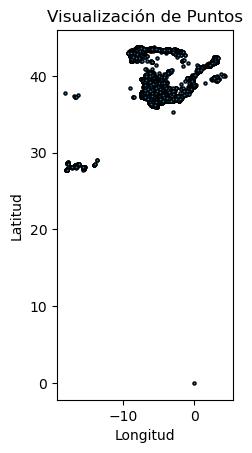

In [16]:
import geopandas as gpd
import matplotlib.pyplot as plt
import sys

# Cargar el shapefile
geodato_prueba = gpd.read_file(sys.argv[1] + "eucpoints.shp")
# Visualizar
geodato_prueba.plot(markersize=5, edgecolor="black")
plt.title("Visualización de Puntos")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()
